# Phase 2

Importing packages that will be used throughout this report

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb

### Research Question
Do geographical and sociopolitical factors impact lung cancer survival rates? If so, which factors and to what degree?

### Data Collection and Cleaning

#### Importing Data Sets

In [2]:
forest_area = pd.read_csv('data/forest_area.csv',thousands=',')
health_expenditure = pd.read_csv('data/health_expenditure.csv',thousands=',')
tuberculosis = pd.read_csv('data/tuberculosis.csv',thousands=',')
urban_pop = pd.read_csv('data/urban_pop.csv',thousands=',')
dollar2_poverty = pd.read_csv('data/dollar2_poverty.csv',thousands=',')
dollar3_poverty = pd.read_csv('data/dollar3_poverty.csv',thousands=',')
current_expenditure = pd.read_csv('data/current_expenditure.csv', thousands = ',')
out_of_pocket = pd.read_csv('data/out_of_pocket.csv',thousands=',')
private_expenditure = pd.read_csv('data/private_expenditure.csv',thousands=',')
cooking_fuel_access = pd.read_csv('data/cooking_fuel_access.csv',thousands=',')
air_pollution = pd.read_csv('data/air_pollution.csv',thousands=',')
physician = pd.read_csv('data/physician.csv',thousands=',')
poverty_10 = pd.read_csv('data/poverty_10.csv',thousands=',')

#### Cleaning Data Sets

We declared the function dropNclean() which drops columns between 1960-1999. We did this because most of the data was missing before year 2000 and the data started from 1960. 
Then we replaced all '..' values to NaN values and dropped countries with more than 30% of the data being NaN.
We renamed the cleaned data by adding 'c_' in front of the original names.

In [3]:
def dropNclean(df):
    df = df.drop(columns=map(str,range(1960,2000)))
    df = df.replace('..',np.NaN)
    return df.dropna(thresh=len(df.columns)*0.7)

c_forest_area = dropNclean(forest_area)
c_health_expenditure = dropNclean(health_expenditure)
c_tuberculosis = dropNclean(tuberculosis)
c_urban_pop = dropNclean(urban_pop)
c_dollar2_poverty = dropNclean(dollar2_poverty)
c_dollar3_poverty = dropNclean(dollar3_poverty)
c_current_expenditure = dropNclean(current_expenditure)
c_out_of_pocket = dropNclean(out_of_pocket)
c_private_expenditure = dropNclean(private_expenditure)
c_cooking_fuel_access = dropNclean(cooking_fuel_access)
c_air_pollution = dropNclean(air_pollution)
c_physician = dropNclean(physician)
c_poverty_10 = dropNclean(poverty_10)

below are the names of all of the data sets

In [4]:
data_names = ['Proportion of Population Pushed Below $2.15 Poverty Line by Out-of-Pocket Health Care Expenditure (%)',
              'Proportion of Population Pushed Below $3.65 Poverty Line by Out-of-Pocket Health Care Expenditure (%)',
              'PM2.5 Air Pollution, Mean Annual Exposure (Mcg per Cubic Meter)',
              'Current Health Expenditure (% of GDP)',
              'Forest Area Coverage (%)',
              'Domestic General Government Health Expenditure per Capita (Current US$)',
              'Out-of-Pocket Ependiture per Capita (Current US$)',
              'Physicians (Per 1000 People)',
              'Proportion of Population Spending More Than 10% of Income on Healthcare (%)',
              'Private Health Expenditure per Capita (Current US$)',
              'Incidence of Tuberculosis (Per 100,000 People)',
              'Urban Population (% of Total Population)'
              ]

cleaned_data is a **list** of the cleaned dataset variables. 
<br> the datasets in cleaned_data have 3 columns, the country, the year, and the value

TODO: make seperate functions rename and melt instead of rename_melt

Here we declared rename_melt() 
- renames the column 'Country Name', which is found in every dataset, to 'Country' 
    - this is for easier processing/ making it less likely to make a mistake 
- melted the dataframe 
    - what does melt mean
    - country is index (what does that mean)
    - years is a column instead of 200,2001,2002... and so on being columns 

In [5]:
cleaned_data = [c_urban_pop, c_dollar2_poverty, c_dollar3_poverty, c_air_pollution,
                  c_current_expenditure, c_forest_area,
                  c_health_expenditure, c_out_of_pocket, c_physician,
                  c_poverty_10, c_private_expenditure, c_tuberculosis]

years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009',
         '2010','2011','2012','2013','2014','2015','2016','2017','2017','2018','2019']

def rename_melt(df, stat):
    df.columns.values[0] = 'Country'

    return df.melt(id_vars=['Country'],
                   value_vars=years,
                   var_name='Year',
                   value_name=stat)

for i in range(len(cleaned_data)):
    cleaned_data[i] = rename_melt(cleaned_data[i], data_names[i])
    cleaned_data[i].iloc[:,-1] = cleaned_data[i].iloc[:,-1].apply(pd.to_numeric, errors='coerce').replace(",","")

Next we saved the intermediate data into csv files.

In [6]:
# export cleaned data to csv files
cleaned_data_names = ['c_urban_pop', 'c_dollar2_poverty', 'c_dollar3_poverty', 'c_air_pollution',
                  'c_current_expenditure', 'c_forest_area',
                  'c_health_expenditure', 'c_out_of_pocket', 'c_physician',
                  'c_poverty_10', 'c_private_expenditure', 'c_tuberculosis']

for i in range(len(cleaned_data)):
    cleaned_data[i].to_csv('data/cleaned_data/' + cleaned_data_names[i], index=False)

Here we merged the dataframes into one big dataframe to make analysis easier.

In [7]:
X = cleaned_data[0]
for df in cleaned_data[1:]:
    X = pd.merge(X, df, on=['Country','Year'], how='left')
X_df = X.set_index('Country')
X.to_csv('data/cleaned_data/X',index=False)
#X_df.to_csv('data/cleaned_data/X_df',index=False)


TODO: How do we want to narrow the dataset for where there are too many NaNs? Proposed solution in next cell

TODO: what should we do with regions vs. countries

In [8]:
drop_cols = ['Proportion of Population Pushed Below $3.65 Poverty Line by Out-of-Pocket Health Care Expenditure (%)',
              'PM2.5 Air Pollution, Mean Annual Exposure (Mcg per Cubic Meter)',
              'Current Health Expenditure (% of GDP)',
              'Proportion of Population Spending More Than 10% of Income on Healthcare (%)',
              'Private Health Expenditure per Capita (Current US$)'
              ]
#X_df = X_df.dropna(axis = 0, thresh=7).drop(columns= drop_cols)

#X_df.head()
X = X.dropna(axis=0, thresh=7).drop(columns = drop_cols)

Alternative with longer names

`X = X.rename(columns = 
             {"Country":"country", 
              "Year":"year" , 
              "Proportion of Population Pushed Below $2.15 Poverty Line by Out-of-Pocket Health Care Expenditure (%)": 
              "moved_below_pov_line",
             "Forest Area Coverage (%)": "forest_area_coverage_percent",
             "Domestic General Government Health Expenditure per Capita (Current US$)": 
              "domestic_gen_gov_health_expenditure",
             "Out-of-Pocket Ependiture per Capita (Current US$)":"out_of_pocket_expenditure_per_capita",
             "Physicians (Per 1000 People)": "physicians_per_1k_ppl",
             "Incidence of Tuberculosis (Per 100,000 People)" : "incidence_tuberculosis_per_100k_ppl",
             "Urban Population (% of Total Population)": "urban_pop_percentage"}) `

In [9]:
X = X.rename(columns = 
             {"Country":"country", 
              "Year":"year" , 
              "Proportion of Population Pushed Below $2.15 Poverty Line by Out-of-Pocket Health Care Expenditure (%)": 
              "pov_line_percent",
             "Forest Area Coverage (%)": "forest_area_percent",
             "Domestic General Government Health Expenditure per Capita (Current US$)": 
              "gov_health_expend",
             "Out-of-Pocket Ependiture per Capita (Current US$)":"ofp_expend",
             "Physicians (Per 1000 People)": "physicians_per_1k",
             "Incidence of Tuberculosis (Per 100,000 People)" : "tuberculosis_per_100k",
             "Urban Population (% of Total Population)": "urban_pop_percent"})
X

,country,year,pov_line_percent,forest_area_percent,gov_health_expend,ofp_expend,physicians_per_1k,tuberculosis_per_100k,urban_pop_percent
4,Angola,2000,50.087,13.0,62.331443,7.567295,3.55,5.37,297.0
5,Albania,2000,41.741,65.15,28.076642,30.314348,33.76,33.76,22.0
6,Andorra,2000,92.395,NaN,34.042553,843.296294,198.15,443.56,21.0
8,United Arab Emirates,2000,80.236,753.08,4.356942,518.345347,166.3,234.73,4.0
9,Argentina,2000,89.142,704.95,12.196486,385.828880,205.17,318.9,37.0
...,...,...,...,...,...,...,...,...,...
5252,Vietnam,2019,36.628,173.65,46.476842,70.536602,78.35,101.41,176.0
5253,Vanuatu,2019,25.394,101.97,36.283839,58.590587,8.24,11.27,41.0
5255,Samoa,2019,18.056,239.13,58.327338,183.720414,25.64,27.61,9.8
5257,South Africa,2019,66.856,550.48,14.085097,321.722103,31.48,222.57,615.0


-------------------------
manipulating data for x

`dict_of_year_dfs` will hold dataframes. Each dataframe will have a **range of countries** but be restricted to a **specific year**. So for example the dataframe associated with '2000' will have hold all of the information avaialbe from 2000

In [10]:
dict_of_year_dfs = {}
for y in years:
    dict_of_year_dfs[y] = X[X["year"] == str(y)]
dict_of_year_dfs['2000'].head()

,country,year,pov_line_percent,forest_area_percent,gov_health_expend,ofp_expend,physicians_per_1k,tuberculosis_per_100k,urban_pop_percent
4,Angola,2000,50.087,13.0,62.331443,7.567295,3.55,5.37,297.0
5,Albania,2000,41.741,65.15,28.076642,30.314348,33.76,33.76,22.0
6,Andorra,2000,92.395,NaN,34.042553,843.296294,198.15,443.56,21.0
8,United Arab Emirates,2000,80.236,753.08,4.356942,518.345347,166.3,234.73,4.0
9,Argentina,2000,89.142,704.95,12.196486,385.828880,205.17,318.9,37.0


`dict_of_country_dfs` will hold dataframes. Each dataframe will have a **range of years**, but be restricted to a **specific country**. So for example the dataframe associated with 'Angola' will have hold all of the information avaialbe from Angloa

In [11]:
countries = X['country'].unique()
dict_of_country_dfs = {}
for c in countries:
    dict_of_country_dfs[c] = X[X['country'] == c]
dict_of_country_dfs['Angola'].head()

,country,year,pov_line_percent,forest_area_percent,gov_health_expend,ofp_expend,physicians_per_1k,tuberculosis_per_100k,urban_pop_percent
4,Angola,2000,50.087,13.0,62.331443,7.567295,3.55,5.37,297.0
267,Angola,2001,51.274,28.93,61.886219,13.201720,13.04,15.31,308.0
530,Angola,2002,52.461,29.05,61.440995,11.419834,14.43,17.26,320.0
793,Angola,2003,53.645,34.87,60.995770,14.403965,16.92,20.1,334.0
1056,Angola,2004,54.827,49.78,60.550546,21.162131,23.34,27.65,350.0


We now have `X` which has all of the information, and two dictionaries (`dict_of_country_dfs`, `dict_of_year_dfs` )of dataframes that break X up into more specified dataframes.

In [12]:
for y in years:
    columns = dict_of_year_dfs[y].columns
    print(f"for the year {y} there are \n{dict_of_year_dfs[y].count()} \ndatapoints \n \n")

for the year 2000 there are 
country                  181
year                     181
pov_line_percent         181
forest_area_percent      156
gov_health_expend        180
ofp_expend               181
physicians_per_1k        180
tuberculosis_per_100k    179
urban_pop_percent        180
dtype: int64 
datapoints 
 

for the year 2001 there are 
country                  181
year                     181
pov_line_percent         181
forest_area_percent      154
gov_health_expend        180
ofp_expend               181
physicians_per_1k        180
tuberculosis_per_100k    179
urban_pop_percent        180
dtype: int64 
datapoints 
 

for the year 2002 there are 
country                  182
year                     182
pov_line_percent         182
forest_area_percent      154
gov_health_expend        181
ofp_expend               182
physicians_per_1k        181
tuberculosis_per_100k    180
urban_pop_percent        181
dtype: int64 
datapoints 
 

for the year 2003 there are 
country       

In [13]:
for c in countries:
    columns = dict_of_country_dfs[c].columns
    print(f"for the country {c} there are \n{dict_of_country_dfs[c].count()} \ndatapoints \n \n")

for the country Angola there are 
country                  20
year                     20
pov_line_percent         20
forest_area_percent      20
gov_health_expend        20
ofp_expend               20
physicians_per_1k        20
tuberculosis_per_100k    20
urban_pop_percent        20
dtype: int64 
datapoints 
 

for the country Albania there are 
country                  19
year                     19
pov_line_percent         19
forest_area_percent      19
gov_health_expend        19
ofp_expend               19
physicians_per_1k        19
tuberculosis_per_100k    19
urban_pop_percent        19
dtype: int64 
datapoints 
 

for the country Andorra there are 
country                  20
year                     20
pov_line_percent         20
forest_area_percent       0
gov_health_expend        20
ofp_expend               20
physicians_per_1k        20
tuberculosis_per_100k    17
urban_pop_percent        20
dtype: int64 
datapoints 
 

for the country United Arab Emirates there are 
count

for the country Timor-Leste there are 
country                  17
year                     17
pov_line_percent         17
forest_area_percent      17
gov_health_expend        17
ofp_expend               17
physicians_per_1k        17
tuberculosis_per_100k    17
urban_pop_percent        17
dtype: int64 
datapoints 
 



Y values dataframe

In [14]:
y = pd.read_csv('./data/cancer.csv',thousands=',')
y = y.rename(columns = {' ' : 'country'})
y = dropNclean(y)
y = y.drop(columns = 'Unnamed: 11').set_index('country')
y = y[years].astype('float64')
y = y.reset_index()
y

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2017,2018,2019
0,Afghanistan,41.7,42.1,42.1,41.5,41.4,40.9,40.5,40.1,39.4,...,37.1,36.6,36.2,35.7,35.6,35.6,35.5,35.5,35.4,35.3
1,Albania,18.7,15.7,16.6,17.3,16.7,20.3,21.4,21.2,20.8,...,19.2,14.4,13.8,13.5,13.6,12.6,12.2,12.2,11.8,11.4
2,Algeria,17.6,17.3,17.1,17.0,16.8,16.6,16.3,16.0,15.7,...,15.0,14.8,14.5,14.3,14.3,14.2,14.1,14.1,13.9,13.9
3,Angola,28.6,28.4,28.1,28.2,28.1,27.1,27.3,25.7,25.8,...,23.8,24.2,24.0,22.8,22.8,22.6,22.1,22.1,22.1,22.2
4,Antigua and Barbuda,18.9,18.2,19.1,18.6,18.3,17.4,17.6,20.1,19.8,...,17.6,16.8,17.3,18.0,18.1,17.7,17.8,17.8,17.7,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,"Venezuela, RB",17.4,17.5,16.9,17.3,16.6,16.5,16.2,16.2,16.3,...,16.6,16.4,16.1,16.5,16.1,16.2,15.9,15.9,15.3,14.8
179,Vietnam,21.6,21.5,21.6,21.6,21.7,21.8,21.9,22.2,22.4,...,22.3,22.3,22.2,22.1,21.9,21.8,21.6,21.6,21.4,21.2
180,"Yemen, Rep.",31.0,30.6,30.1,29.7,29.4,29.1,28.7,28.4,28.3,...,27.2,27.1,26.9,26.7,26.6,26.8,27.1,27.1,27.4,27.6
181,Zambia,33.0,32.1,31.4,30.7,30.9,30.4,30.0,28.7,27.8,...,28.3,27.6,27.2,26.9,26.6,26.4,26.2,26.2,25.6,24.6


TODO: want summary statistics for Y in the exploratory data

### Data Description

TODO: fix 15 datasets to 12 datasets <br>
Individually, we selected 5 factors we thought are likely to impact the lung cancer survival rate for a total of 15 data sets. These datasets are all sourced from the WorldBank site. The 16th data set is the data set of lung cancer survival rates by country and by year. 

**What are the observations (rows) and the attributes (columns)?:** 
While it differs slightly across dataframes, most columns follow this convention:
- 'Country Name' - the name of the relevant country
- 'Country Code' - the internationally recognized cataloguing abbreviation of the country
- 'Indicator Name' - The name of the relevant World Development Indicator, in addition to its unit
- 'Indicator Code' - the cataloguing abbreviation for the relevant World Development Indicator
- '1960', '1961',... - the relevant year of the data

Rows are principally by country name.

**Why was the dataset created? Who funded it?:** The data is all sourced from The World Bank. "The World Bank Group is one of the world’s largest sources of funding and knowledge for developing countries. Its five institutions share a commitment to reducing poverty, increasing shared prosperity, and promoting sustainable development." The World Bank collects the geographic and sociopolitical data used here, to better inform where and how funding is distributed on an international scale. https://www.worldbank.org/en/who-we-are

**What processes might have influenced what data was observed and recorded and what was not?** 
Though logistically difficult and expensive, the collection of world development indidicator data is an important part of any country's ability to recognize areas of opportunity for national improvement and the needs of communities. For example, with our world development indicators, countries with high rates of mortality from cancer may question the flaws in their infrastructure that leads to such negative outcomes. The influences that affect the recording of data can be nefarious, however. Countries may twist data to mislead international bodies, allies, and rivals, with high-impact indicators such as financial rates often being twisted to encourage foreign investment.

**What preprocessing was done, and how did the data come to be in the form that you are using?** We downloaded the csv files from the world bank. The datasets came in packs of three csv files, two of which consisted only of metadata. We discarded the two files of metadata. For the remaining csv file which had all of the relevent data, we deleted the first 4 lines.

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?** 
The source of our data is likely government census data. As such, citizens of countries recognize that as a part of that country's population, they should contribute to that country's bank of data regarding their citizens. In the same way that taxes and birth certificates are filed and issued, as citizens we expect the government to keep a basic profile on all of us, whether that be in the form of simply affirming existence, or logging cancer mortality and household income.

**Where can your raw source data be found, if applicable?** Raw source Data can be found from where we got our csv files at https://data.worldbank.org/indicator . They can also be found on our github repository in the folder called data : https://github.coecis.cornell.edu/mk932/INFO2950_Project_Team.git .

We are hoping to explore possibilities of causation further down the road, but for phase 2 we will be looking for correlations between the factors and the survival rate.

### Data Limitations

- Since our data is mainly sourced from a single website (The World Bank), most of our data faces the same limitations as well. For example, all of our dataframes lack any data for years before 2000, and also vary in the amount of NaNs that exist even outside of those years. There is a varying amount of documentation for varying countries, with those like the United States and Norway having almost complete information, while countries such as Angora and Afghanistan may lack information for a few years. Dealing with these NaN values will impact what subset of years we decide to analyze, and additionally what countries may not be suitable for an exploratory data analysis due to a lack of data.
- We are assuming different indicators affect different countries to the same degree. For example, depending on the countries location, forest area might not have as much of an impact. We selected the forest area dataframe because forests impact levels of air pollution which in turn effects incidence and survival rates of lung cancer. However the impact of forests on air pollution is dependent on geographical factors such as the alltitude, climate, and biomes of a country. Additionally, we are only looking at the forest area within the borders of a country. Most likely this will not have too much of an effect on large countries such as the U.S. or Canada, but smaller countries closely packed together such as the ones in Europe, could be greatly impacted.
- The data sets we included are not immedietly related to lung cancer. For example instead of using a dataset 'tuburculosis incidence per 100000 people', a data set that looked for 'incidence rates of turboculosis patients that later developed lung cancer' would be less removed. The closer degrees of relevance a dataset can have, the more likely high correlations actually means something. Basically, our data set is limiting how far we can take possible interpretaions of our data analysis.
- Like any project including data, there are underlying variables that are not immedieatly obvious. An example of a potential underlying variable not considered in our data is age groups. We can not know if someone who passed away at 80 actually passed away because of lung cancer, other medical issues, old age, or a combination. Additionally differeces in access to medical care depending on age, race/ethnicity are hard to properly gauge. Survival rates of lung cancer only looks at the people who had some form of medical access and thus could be documented. In countries like the U.S. where medical care is privatized and many do not go to hospitals for fear of the bills they would incur, there is a significant population that goes unrecognized by the pulled data sets. 

### Exploratory data Analysis

We wanted to see the correlation matrix but could not due to an error in reading the csv files.

In [15]:
#need to use a different column as a refrence column? or do we even need refrence column when we are not dealing
#with a binary dependent variable? 
#correlation_matrix = X_df.drop(columns='Current Health Expenditure (% of GDP)').corr()

#correlation_matrix

In [16]:
def describe_country_stats(c):
    columns = dict_of_country_dfs[c].columns[2:]
    print(f"for the country {c} \n\nthe mean for each category is \n{dict_of_country_dfs[c].get(columns).mean()} \n")
    print(f"the median for each category is \n{dict_of_country_dfs[c].get(columns).median()}\n")
    print(f"the variance for each category is \n{dict_of_country_dfs[c].get(columns).var()}\n")

In [17]:
country_means_dict = {}
country_medians_dict = {}
country_variances_dict = {}
columns = dict_of_country_dfs['Bulgaria'].columns[2:]

In [18]:
hold = y.set_index('country')
hold = hold.transpose()
y_stat = pd.DataFrame(data = [hold.mean(), hold.median(), hold.var()]).transpose().reset_index()
y_stat = y_stat.rename(columns = {0 : 'y_mean', 1 : 'y_median' , 2 : 'y_variance'})

In [19]:
for c in countries:
    country_means_dict[c] = dict_of_country_dfs[c].get(columns).mean()
    country_medians_dict[c] = dict_of_country_dfs[c].get(columns).mean()
    country_variances_dict[c] = dict_of_country_dfs[c].get(columns).mean()

In [20]:
country_means_df = pd.DataFrame(data=country_means_dict).transpose()
country_means_df = country_means_df.reset_index().rename(columns = {'index' : 'country'})
country_means_df = pd.merge(country_means_df,y_stat,left_on = ['country'], right_on = ['country'])

In [21]:
country_medians_df = pd.DataFrame(data=country_medians_dict).transpose()
country_medians_df = country_medians_df.reset_index().rename(columns = {'index' : 'country'})
country_medians_df = pd.merge(country_medians_df,y_stat,left_on = ['country'], right_on = ['country'])

In [22]:
country_variances_df = pd.DataFrame(data=country_variances_dict).transpose()
country_variances_df = country_variances_df.reset_index().rename(columns = {'index' : 'country'})
country_variances_df = pd.merge(country_variances_df,y_stat,left_on = ['country'], right_on = ['country'])

C:\Users\asela\anaconda3\envs\info2950\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\asela\anaconda3\envs\info2950\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\asela\anaconda3\envs\info2950\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='country', ylabel='pov_line_percent'>

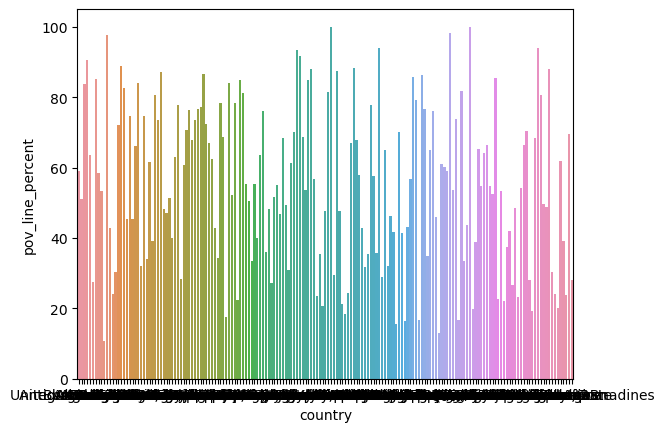

In [23]:
sns.barplot(data=country_means_df, x="country", y="pov_line_percent")

C:\Users\asela\anaconda3\envs\info2950\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\asela\anaconda3\envs\info2950\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='pov_line_percent', ylabel='y_mean'>

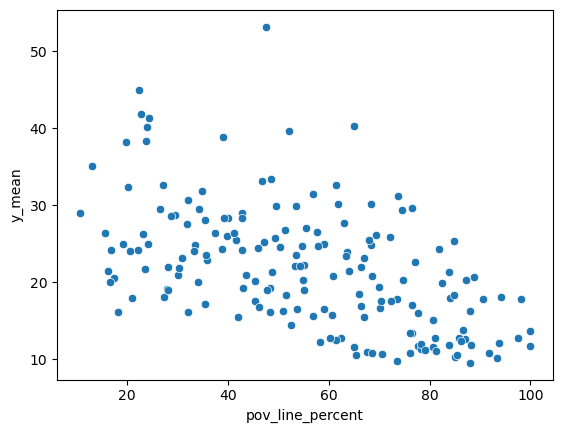

In [24]:
sns.scatterplot(data=country_means_df, x="pov_line_percent", y="y_mean")

In [25]:
sns.barplot(data=y_stat, x="country", y="mean")

ValueError: Could not interpret input 'mean'

TODO: scatter plots 

TODO: what do these correlations say? why do we care about them? anything surprising?

### Questions for Reviewers

- We wanted to do a correlation matrix for exploratory data analysis but could not because the thousands seperator did not work leaving all values that exceed 1,000 to be left as strings. What could be the possible cause of this?